In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import cv2
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
image_path="/kaggle/input/yoga-pose-image-classification-dataset/dataset/"

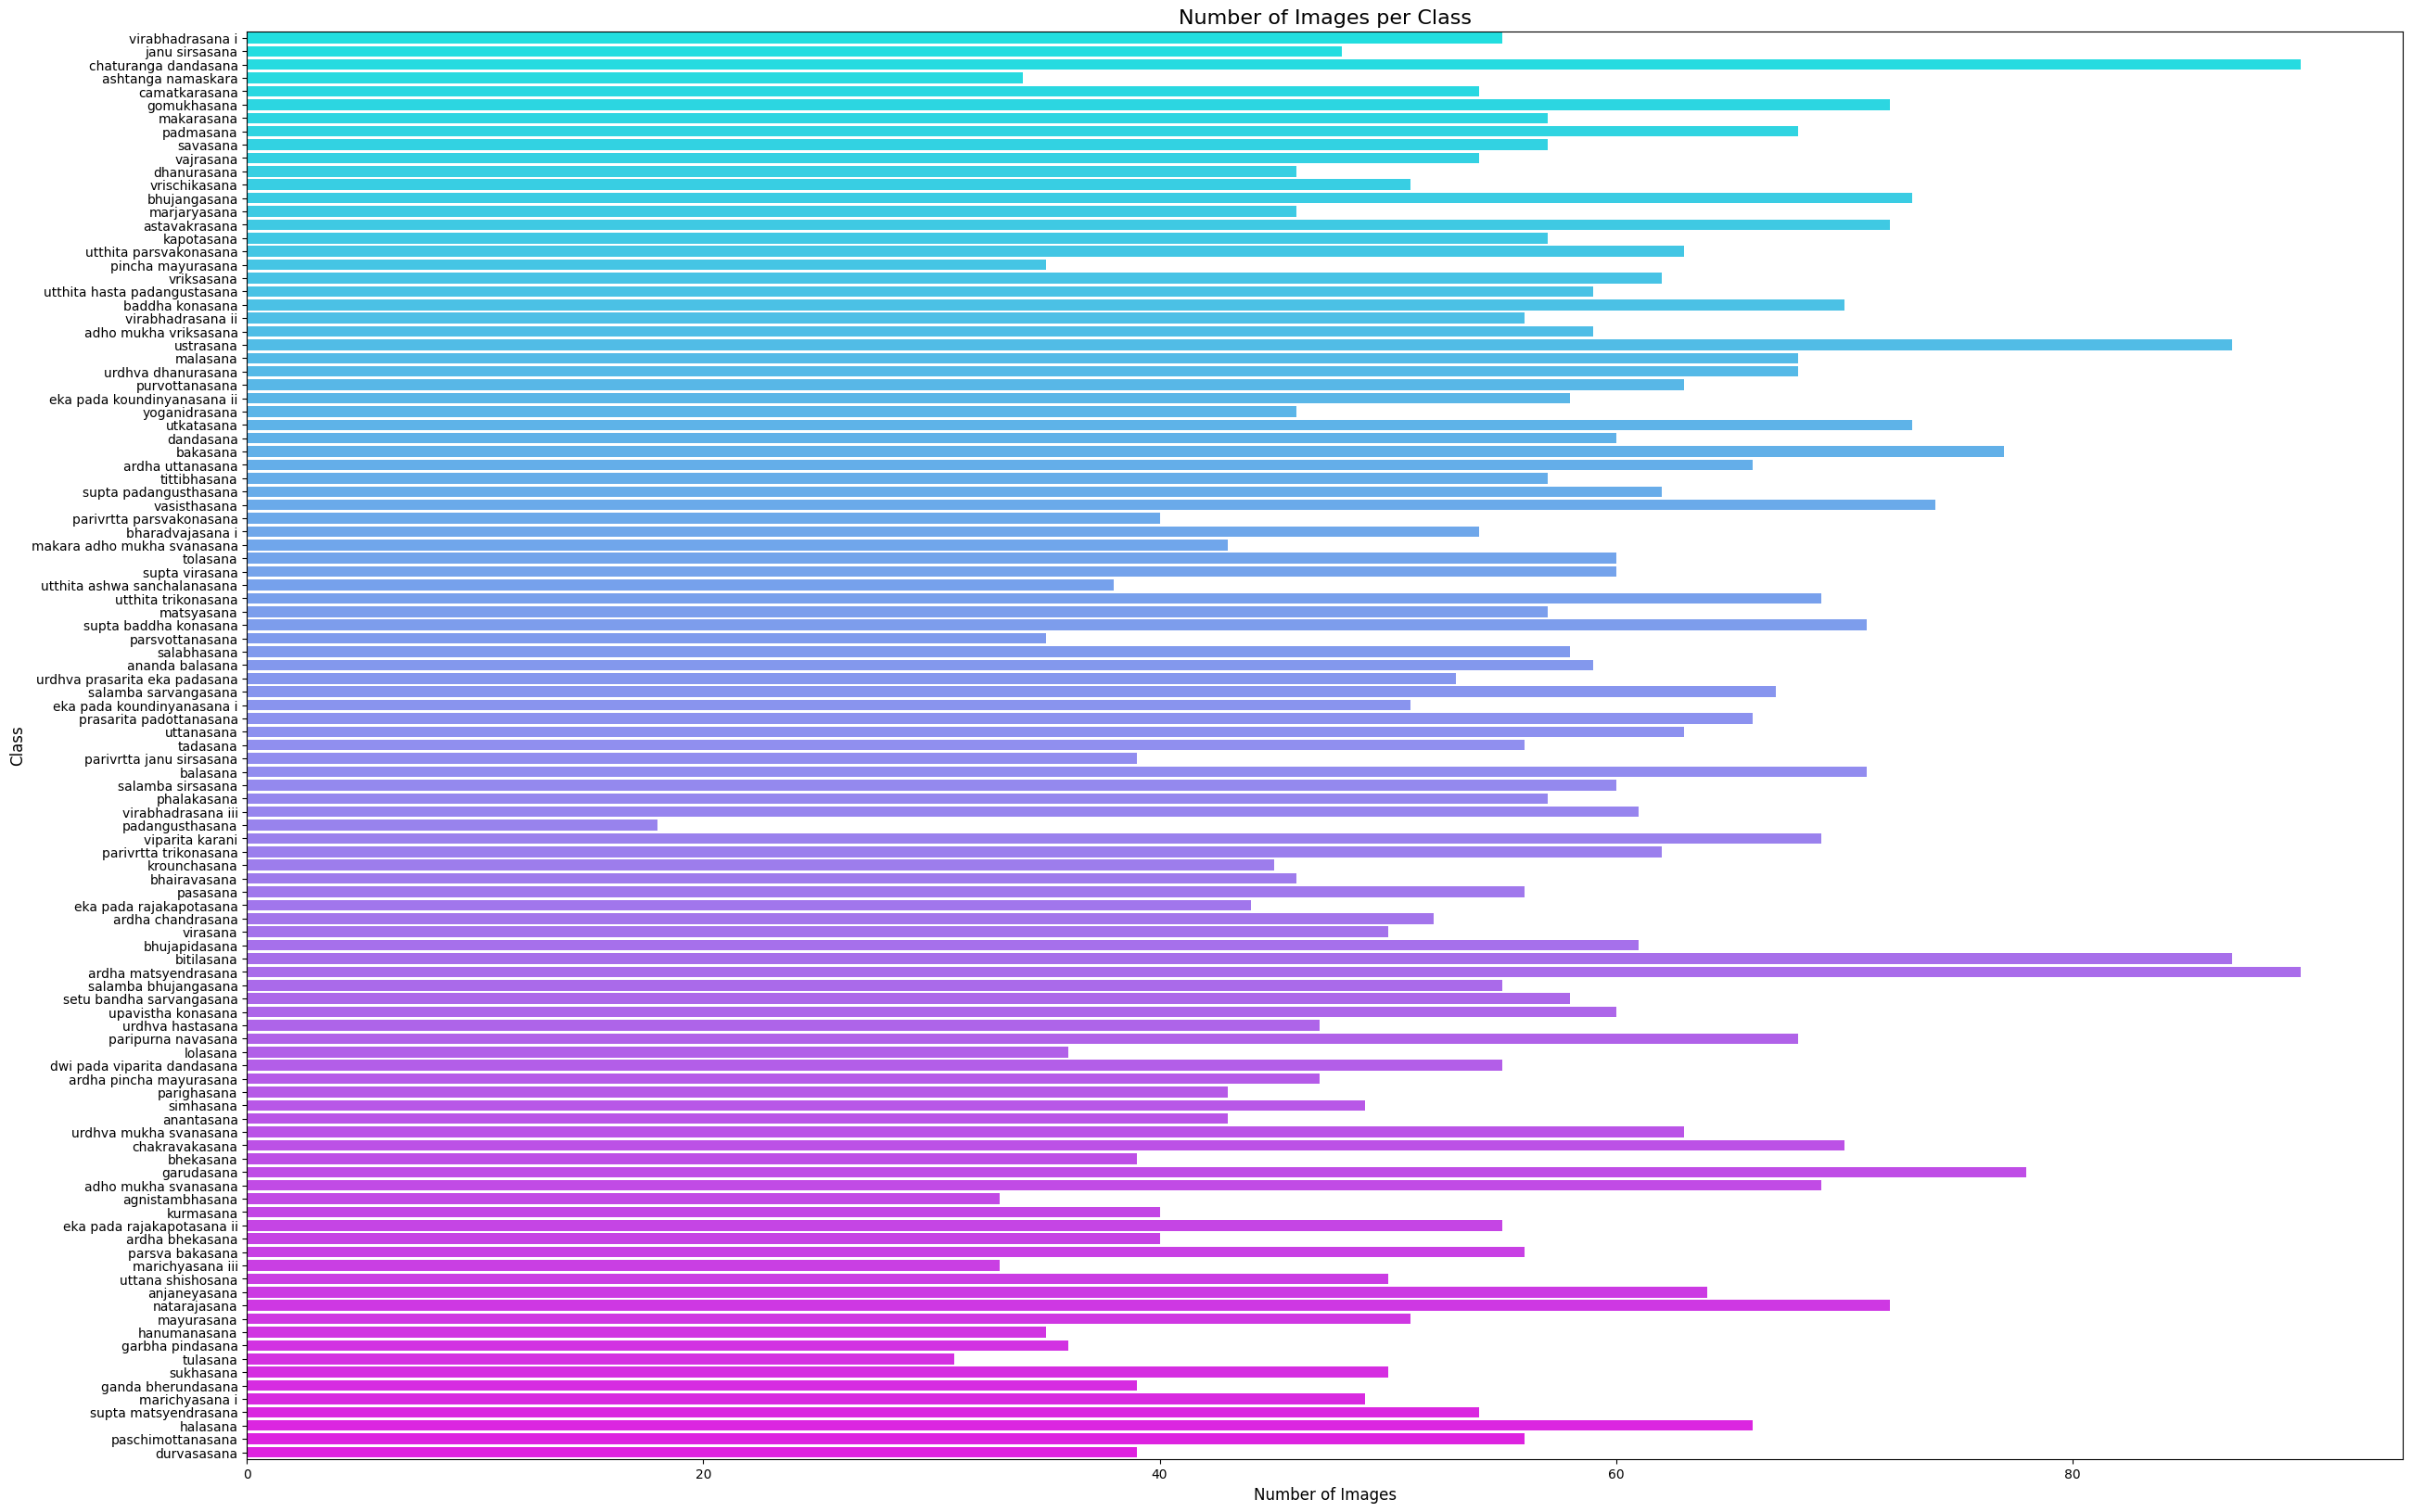

In [3]:
# Get the list of all subdirectories (classes)
classes = os.listdir(image_path)

# Initialize an empty list to store labels
labels = []

# Loop through each class and get the number of images in each class
for class_name in classes:
    class_dir = os.path.join(image_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_images = len(os.listdir(class_dir))  # Count number of images in each class
        labels.extend([class_name] * num_images)  # Append the class label for each image

# Count the number of images per class
label_counts = Counter(labels)

# Convert the label counts into a DataFrame for seaborn

label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])

# Create the seaborn barplot
plt.figure(figsize=(30,20))
sns.barplot(x='Count', y='Class', data=label_counts_df, palette='cool')

# Add title and labels
plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)

# Show the plot
plt.show()

# Visualize some images from dataset

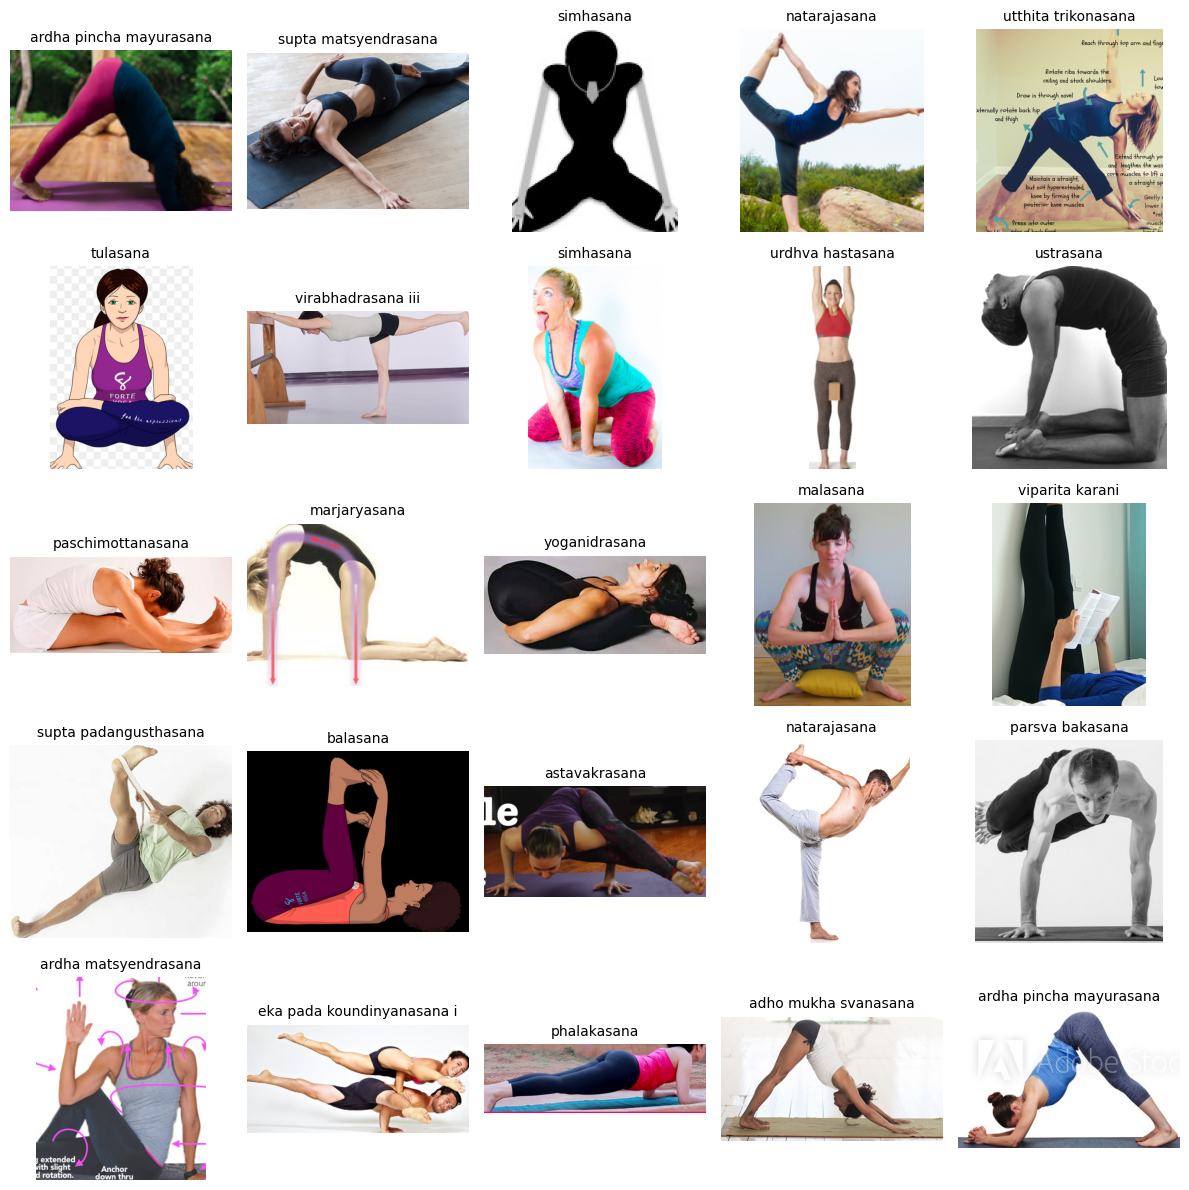

In [4]:
# Get folder names (class labels)
class_labels = os.listdir(image_path)

# Create a list of (image_path, label) pairs
image_files = []
for label in class_labels:
    class_folder = os.path.join(image_path, label)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        image_files.extend([(os.path.join(class_folder, img), label) for img in images])

# Shuffle and select 25 images
random.shuffle(image_files)
selected_images = image_files[:25]

# Plot images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    img_path, label = selected_images[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Store images and labels

In [5]:
class_labels=sorted(os.listdir(image_path))
label_dict={label : idx for idx,label in enumerate(class_labels)}

image_data=[]
image_labels=[]

for label in tqdm(class_labels,desc="Processing Classes"):
    folder_path=os.path.join(image_path,label)
    if os.path.isdir(folder_path):
        for img_name in tqdm(os.listdir(folder_path),desc=f"Loading : {label}",leave=False):
            img_path=os.path.join(folder_path,img_name)
            img=cv2.imread(img_path)


            if img is not None:
                img=cv2.resize(img,(224,224))
                image_data.append(img)
                image_labels.append(label_dict[label])


X=np.array(image_data)/255.0

y=np.array(image_labels)

y_onehot_label=to_categorical(y,num_classes=len(class_labels))

Loading : padangusthasana:   0%|          | 0/18 [00:00<?, ?it/s]
                                                                 
Processing Classes: 100%|██████████| 107/107 [00:31<00:00,  3.38it/s]    


In [6]:
print(f"\n✅ Data Shape: {X.shape}, Labels Shape (One-Hot): {y_onehot_label.shape}")
print("Label Mapping:", label_dict)


✅ Data Shape: (5992, 224, 224, 3), Labels Shape (One-Hot): (5992, 107)
Label Mapping: {'adho mukha svanasana': 0, 'adho mukha vriksasana': 1, 'agnistambhasana': 2, 'ananda balasana': 3, 'anantasana': 4, 'anjaneyasana': 5, 'ardha bhekasana': 6, 'ardha chandrasana': 7, 'ardha matsyendrasana': 8, 'ardha pincha mayurasana': 9, 'ardha uttanasana': 10, 'ashtanga namaskara': 11, 'astavakrasana': 12, 'baddha konasana': 13, 'bakasana': 14, 'balasana': 15, 'bhairavasana': 16, 'bharadvajasana i': 17, 'bhekasana': 18, 'bhujangasana': 19, 'bhujapidasana': 20, 'bitilasana': 21, 'camatkarasana': 22, 'chakravakasana': 23, 'chaturanga dandasana': 24, 'dandasana': 25, 'dhanurasana': 26, 'durvasasana': 27, 'dwi pada viparita dandasana': 28, 'eka pada koundinyanasana i': 29, 'eka pada koundinyanasana ii': 30, 'eka pada rajakapotasana': 31, 'eka pada rajakapotasana ii': 32, 'ganda bherundasana': 33, 'garbha pindasana': 34, 'garudasana': 35, 'gomukhasana': 36, 'halasana': 37, 'hanumanasana': 38, 'janu sirs

## **What exactly are we doing?**

We're taking the output of the last CONV-POOL layer (see below). 

The output shape at this layer is **7 x 7 x 512**

![feat_extraction](https://appliedmachinelearning.files.wordpress.com/2021/05/ef54e-vgg16.png?w=612&zoom=2)
Image referenced from [here](https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/)

# Load VGG16 Model

In [7]:
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Extract our Features using VGG16

In [8]:

# List to store image paths and labels
image_paths = []
labels = []

# Collect image paths and corresponding labels
for label in class_labels:
    folder_path = os.path.join(image_path, label)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file_path.endswith(('jpg', 'jpeg', 'png')):  # Filter out image files
                image_paths.append(file_path)
                labels.append(label_dict[label])  # Append the label index

# Set batch size
batch_size = 32
image_features = []
image_labels = []

# Loop over batches with tqdm progress bar
for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting Features"):
    # Extract the current batch
    batch_paths = image_paths[i:i + batch_size]
    batch_labels = labels[i:i + batch_size]
    batch_images = []

    # Iterate over each image in the batch
    for image_path in batch_paths:
        # Load and preprocess the image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)  # Expand dimensions for model input
        image = preprocess_input(image)  # Preprocess the image for VGG16

        batch_images.append(image)  # Append the processed image

    # Stack the batch images into the correct format
    batch_images = np.vstack(batch_images)

    # Extract features using the model
    features = model.predict(batch_images, batch_size=batch_size)

    # Flatten features from (7, 7, 512) to (batch_size, 7*7*512)
    features = features.reshape(batch_images.shape[0], -1)

    # Store the features and labels
    image_features.append(features)
    image_labels.append(batch_labels)

# Flatten the feature arrays and label arrays
image_features_data = np.vstack(image_features)  # Stack all feature batches
image_labels_data = np.hstack(image_labels)  # Flatten all labels

print(f"✅ Feature Shape: {image_features_data.shape}, Labels Shape: {image_labels_data.shape}")


Extracting Features:   0%|          | 0/188 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Extracting Features:   1%|          | 1/188 [00:08<25:05,  8.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:   1%|          | 2/188 [00:08<11:06,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting Features:   2%|▏         | 3/188 [00:08<06:25,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:   2%|▏         | 4/188 [00:09<04:12,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:   3%|▎         | 5/188 [00:09<02:59,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:   3%|▎         | 6/188 [00:09<02:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:   4%|▎         | 7/188 [00:09<01:49,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:   4%|▍         | 8/188 [00:10<01:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:   5%|▍         | 9/188 [00:10<01:21,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   5%|▌         | 10/188 [00:10<01:12,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   6%|▌         | 11/188 [00:11<01:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   6%|▋         | 12/188 [00:11<01:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   7%|▋         | 13/188 [00:11<01:00,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   7%|▋         | 14/188 [00:12<00:55,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   8%|▊         | 15/188 [00:12<00:53,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:   9%|▊         | 16/188 [00:12<00:52,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   9%|▉         | 17/188 [00:12<00:51,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  10%|▉         | 18/188 [00:13<00:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  10%|█         | 19/188 [00:13<00:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  11%|█         | 20/188 [00:13<00:49,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  11%|█         | 21/188 [00:14<00:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  12%|█▏        | 22/188 [00:14<00:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  12%|█▏        | 23/188 [00:14<00:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  13%|█▎        | 24/188 [00:15<00:55,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  13%|█▎        | 25/188 [00:15<00:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  14%|█▍        | 26/188 [00:15<00:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  14%|█▍        | 27/188 [00:16<00:51,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  15%|█▍        | 28/188 [00:16<00:51,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  15%|█▌        | 29/188 [00:16<00:54,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  16%|█▌        | 30/188 [00:17<00:54,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  16%|█▋        | 31/188 [00:17<00:52,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  17%|█▋        | 32/188 [00:17<00:49,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  18%|█▊        | 33/188 [00:18<00:48,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  18%|█▊        | 34/188 [00:18<00:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  19%|█▊        | 35/188 [00:18<00:46,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  19%|█▉        | 36/188 [00:18<00:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  20%|█▉        | 37/188 [00:19<00:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  20%|██        | 38/188 [00:19<00:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  21%|██        | 39/188 [00:19<00:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  21%|██▏       | 40/188 [00:20<00:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  22%|██▏       | 41/188 [00:20<00:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  22%|██▏       | 42/188 [00:20<00:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  23%|██▎       | 43/188 [00:20<00:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  23%|██▎       | 44/188 [00:21<00:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  24%|██▍       | 45/188 [00:21<00:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  24%|██▍       | 46/188 [00:21<00:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  25%|██▌       | 47/188 [00:22<00:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  26%|██▌       | 48/188 [00:22<00:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  26%|██▌       | 49/188 [00:22<00:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  27%|██▋       | 50/188 [00:23<00:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting Features:  27%|██▋       | 51/188 [00:23<00:40,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  28%|██▊       | 52/188 [00:23<00:40,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting Features:  28%|██▊       | 53/188 [00:23<00:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  29%|██▊       | 54/188 [00:24<00:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  29%|██▉       | 55/188 [00:24<00:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  30%|██▉       | 56/188 [00:24<00:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  30%|███       | 57/188 [00:24<00:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  31%|███       | 58/188 [00:25<00:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  31%|███▏      | 59/188 [00:25<00:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  32%|███▏      | 60/188 [00:25<00:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  32%|███▏      | 61/188 [00:26<00:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  33%|███▎      | 62/188 [00:26<00:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  34%|███▎      | 63/188 [00:26<00:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  34%|███▍      | 64/188 [00:26<00:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  35%|███▍      | 65/188 [00:27<00:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  35%|███▌      | 66/188 [00:27<00:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  36%|███▌      | 67/188 [00:27<00:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  36%|███▌      | 68/188 [00:28<00:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  37%|███▋      | 69/188 [00:28<00:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  37%|███▋      | 70/188 [00:28<00:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  38%|███▊      | 71/188 [00:28<00:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  38%|███▊      | 72/188 [00:29<00:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  39%|███▉      | 73/188 [00:29<00:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  39%|███▉      | 74/188 [00:29<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  40%|███▉      | 75/188 [00:30<00:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  40%|████      | 76/188 [00:30<00:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  41%|████      | 77/188 [00:30<00:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting Features:  41%|████▏     | 78/188 [00:30<00:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  42%|████▏     | 79/188 [00:31<00:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  43%|████▎     | 80/188 [00:31<00:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  43%|████▎     | 81/188 [00:31<00:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  44%|████▎     | 82/188 [00:32<00:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  44%|████▍     | 83/188 [00:32<00:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting Features:  45%|████▍     | 84/188 [00:32<00:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  45%|████▌     | 85/188 [00:32<00:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  46%|████▌     | 86/188 [00:33<00:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  46%|████▋     | 87/188 [00:33<00:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting Features:  47%|████▋     | 88/188 [00:33<00:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  47%|████▋     | 89/188 [00:34<00:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  48%|████▊     | 90/188 [00:34<00:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  48%|████▊     | 91/188 [00:34<00:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  49%|████▉     | 92/188 [00:34<00:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  49%|████▉     | 93/188 [00:35<00:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  50%|█████     | 94/188 [00:35<00:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  51%|█████     | 95/188 [00:36<00:36,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  51%|█████     | 96/188 [00:36<00:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  52%|█████▏    | 97/188 [00:36<00:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  52%|█████▏    | 98/188 [00:37<00:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 99/188 [00:37<00:27,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  53%|█████▎    | 100/188 [00:37<00:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  54%|█████▎    | 101/188 [00:37<00:26,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  54%|█████▍    | 102/188 [00:38<00:26,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  55%|█████▍    | 103/188 [00:38<00:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  55%|█████▌    | 104/188 [00:38<00:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  56%|█████▌    | 105/188 [00:39<00:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  56%|█████▋    | 106/188 [00:39<00:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  57%|█████▋    | 107/188 [00:39<00:24,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  57%|█████▋    | 108/188 [00:39<00:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  58%|█████▊    | 109/188 [00:40<00:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  59%|█████▊    | 110/188 [00:40<00:24,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  59%|█████▉    | 111/188 [00:40<00:25,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  60%|█████▉    | 112/188 [00:41<00:23,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  60%|██████    | 113/188 [00:41<00:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  61%|██████    | 114/188 [00:41<00:22,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:  61%|██████    | 115/188 [00:42<00:23,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  62%|██████▏   | 116/188 [00:42<00:23,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 117/188 [00:42<00:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  63%|██████▎   | 118/188 [00:43<00:20,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  63%|██████▎   | 119/188 [00:43<00:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  64%|██████▍   | 120/188 [00:43<00:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  64%|██████▍   | 121/188 [00:43<00:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  65%|██████▍   | 122/188 [00:44<00:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▌   | 123/188 [00:44<00:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▌   | 124/188 [00:44<00:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▋   | 125/188 [00:44<00:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 126/188 [00:45<00:18,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  68%|██████▊   | 127/188 [00:46<00:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  68%|██████▊   | 128/188 [00:46<00:24,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  69%|██████▊   | 129/188 [00:46<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  69%|██████▉   | 130/188 [00:47<00:20,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 131/188 [00:47<00:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|███████   | 132/188 [00:47<00:17,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  71%|███████   | 133/188 [00:47<00:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████▏  | 134/188 [00:48<00:16,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting Features:  72%|███████▏  | 135/188 [00:48<00:16,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  72%|███████▏  | 136/188 [00:48<00:16,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  73%|███████▎  | 137/188 [00:49<00:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  73%|███████▎  | 138/188 [00:49<00:15,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  74%|███████▍  | 139/188 [00:49<00:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  74%|███████▍  | 140/188 [00:50<00:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  75%|███████▌  | 141/188 [00:50<00:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  76%|███████▌  | 142/188 [00:50<00:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:  76%|███████▌  | 143/188 [00:50<00:13,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting Features:  77%|███████▋  | 144/188 [00:51<00:13,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting Features:  77%|███████▋  | 145/188 [00:51<00:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  78%|███████▊  | 146/188 [00:51<00:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  78%|███████▊  | 147/188 [00:52<00:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▊  | 148/188 [00:52<00:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▉  | 149/188 [00:52<00:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  80%|███████▉  | 150/188 [00:52<00:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  80%|████████  | 151/188 [00:53<00:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  81%|████████  | 152/188 [00:53<00:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  81%|████████▏ | 153/188 [00:53<00:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  82%|████████▏ | 154/188 [00:54<00:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  82%|████████▏ | 155/188 [00:54<00:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  83%|████████▎ | 156/188 [00:54<00:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  84%|████████▎ | 157/188 [00:54<00:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  84%|████████▍ | 158/188 [00:55<00:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▍ | 159/188 [00:55<00:09,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  85%|████████▌ | 160/188 [00:55<00:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  86%|████████▌ | 161/188 [00:56<00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  86%|████████▌ | 162/188 [00:56<00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  87%|████████▋ | 163/188 [00:56<00:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  87%|████████▋ | 164/188 [00:57<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  88%|████████▊ | 165/188 [00:57<00:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  88%|████████▊ | 166/188 [00:57<00:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  89%|████████▉ | 167/188 [00:57<00:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  89%|████████▉ | 168/188 [00:58<00:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  90%|████████▉ | 169/188 [00:58<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|█████████ | 170/188 [00:58<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  91%|█████████ | 171/188 [00:59<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting Features:  91%|█████████▏| 172/188 [00:59<00:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  92%|█████████▏| 173/188 [00:59<00:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  93%|█████████▎| 174/188 [00:59<00:04,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  93%|█████████▎| 175/188 [01:00<00:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▎| 176/188 [01:00<00:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  94%|█████████▍| 177/188 [01:01<00:04,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  95%|█████████▍| 178/188 [01:01<00:04,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  95%|█████████▌| 179/188 [01:02<00:03,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  96%|█████████▌| 180/188 [01:02<00:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  96%|█████████▋| 181/188 [01:02<00:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  97%|█████████▋| 182/188 [01:03<00:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  97%|█████████▋| 183/188 [01:03<00:01,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  98%|█████████▊| 184/188 [01:03<00:01,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  98%|█████████▊| 185/188 [01:04<00:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  99%|█████████▉| 186/188 [01:04<00:00,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  99%|█████████▉| 187/188 [01:04<00:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting Features: 100%|██████████| 188/188 [01:07<00:00,  2.80it/s]

✅ Feature Shape: (5991, 25088), Labels Shape: (5991,)


# First let's store our extracted feature info in a format that can loaded directly by sklearn.

In [9]:

imageLabels_data =  [lb for label_batch in image_labels for lb in label_batch]
imageFeatures_data = [feature for feature_batch in image_features for feature in feature_batch]
image_labels_data = np.array(imageLabels_data)
image_features_data = np.array(imageFeatures_data)

# Split Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_features_data,image_labels_data, test_size=0.2, random_state = 42)

In [11]:
print(f"Train Data Shape : {X_train.shape}")
print(f"Test Data Shape : {X_test.shape}")
print(f"Train Label Shape : {y_train.shape}")
print(f"Test label Shape : {y_train.shape}")

Train Data Shape : (4792, 25088)
Test Data Shape : (1199, 25088)
Train Label Shape : (4792,)
Test label Shape : (4792,)


# Build Model

In [12]:
lr = LogisticRegression(C=0.1,multi_class="auto",class_weight="balanced",random_state=42)
lr.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, class_weight='balanced', random_state=42)

# Get Accruacy on the 20% we split from our training dataset

In [13]:

accuracy = lr.score(X_test, y_test)
print(f'Accuracy on validation set using Logistic Regression: {accuracy*100}%')

Accuracy on validation set using Logistic Regression: 67.38949124270225%


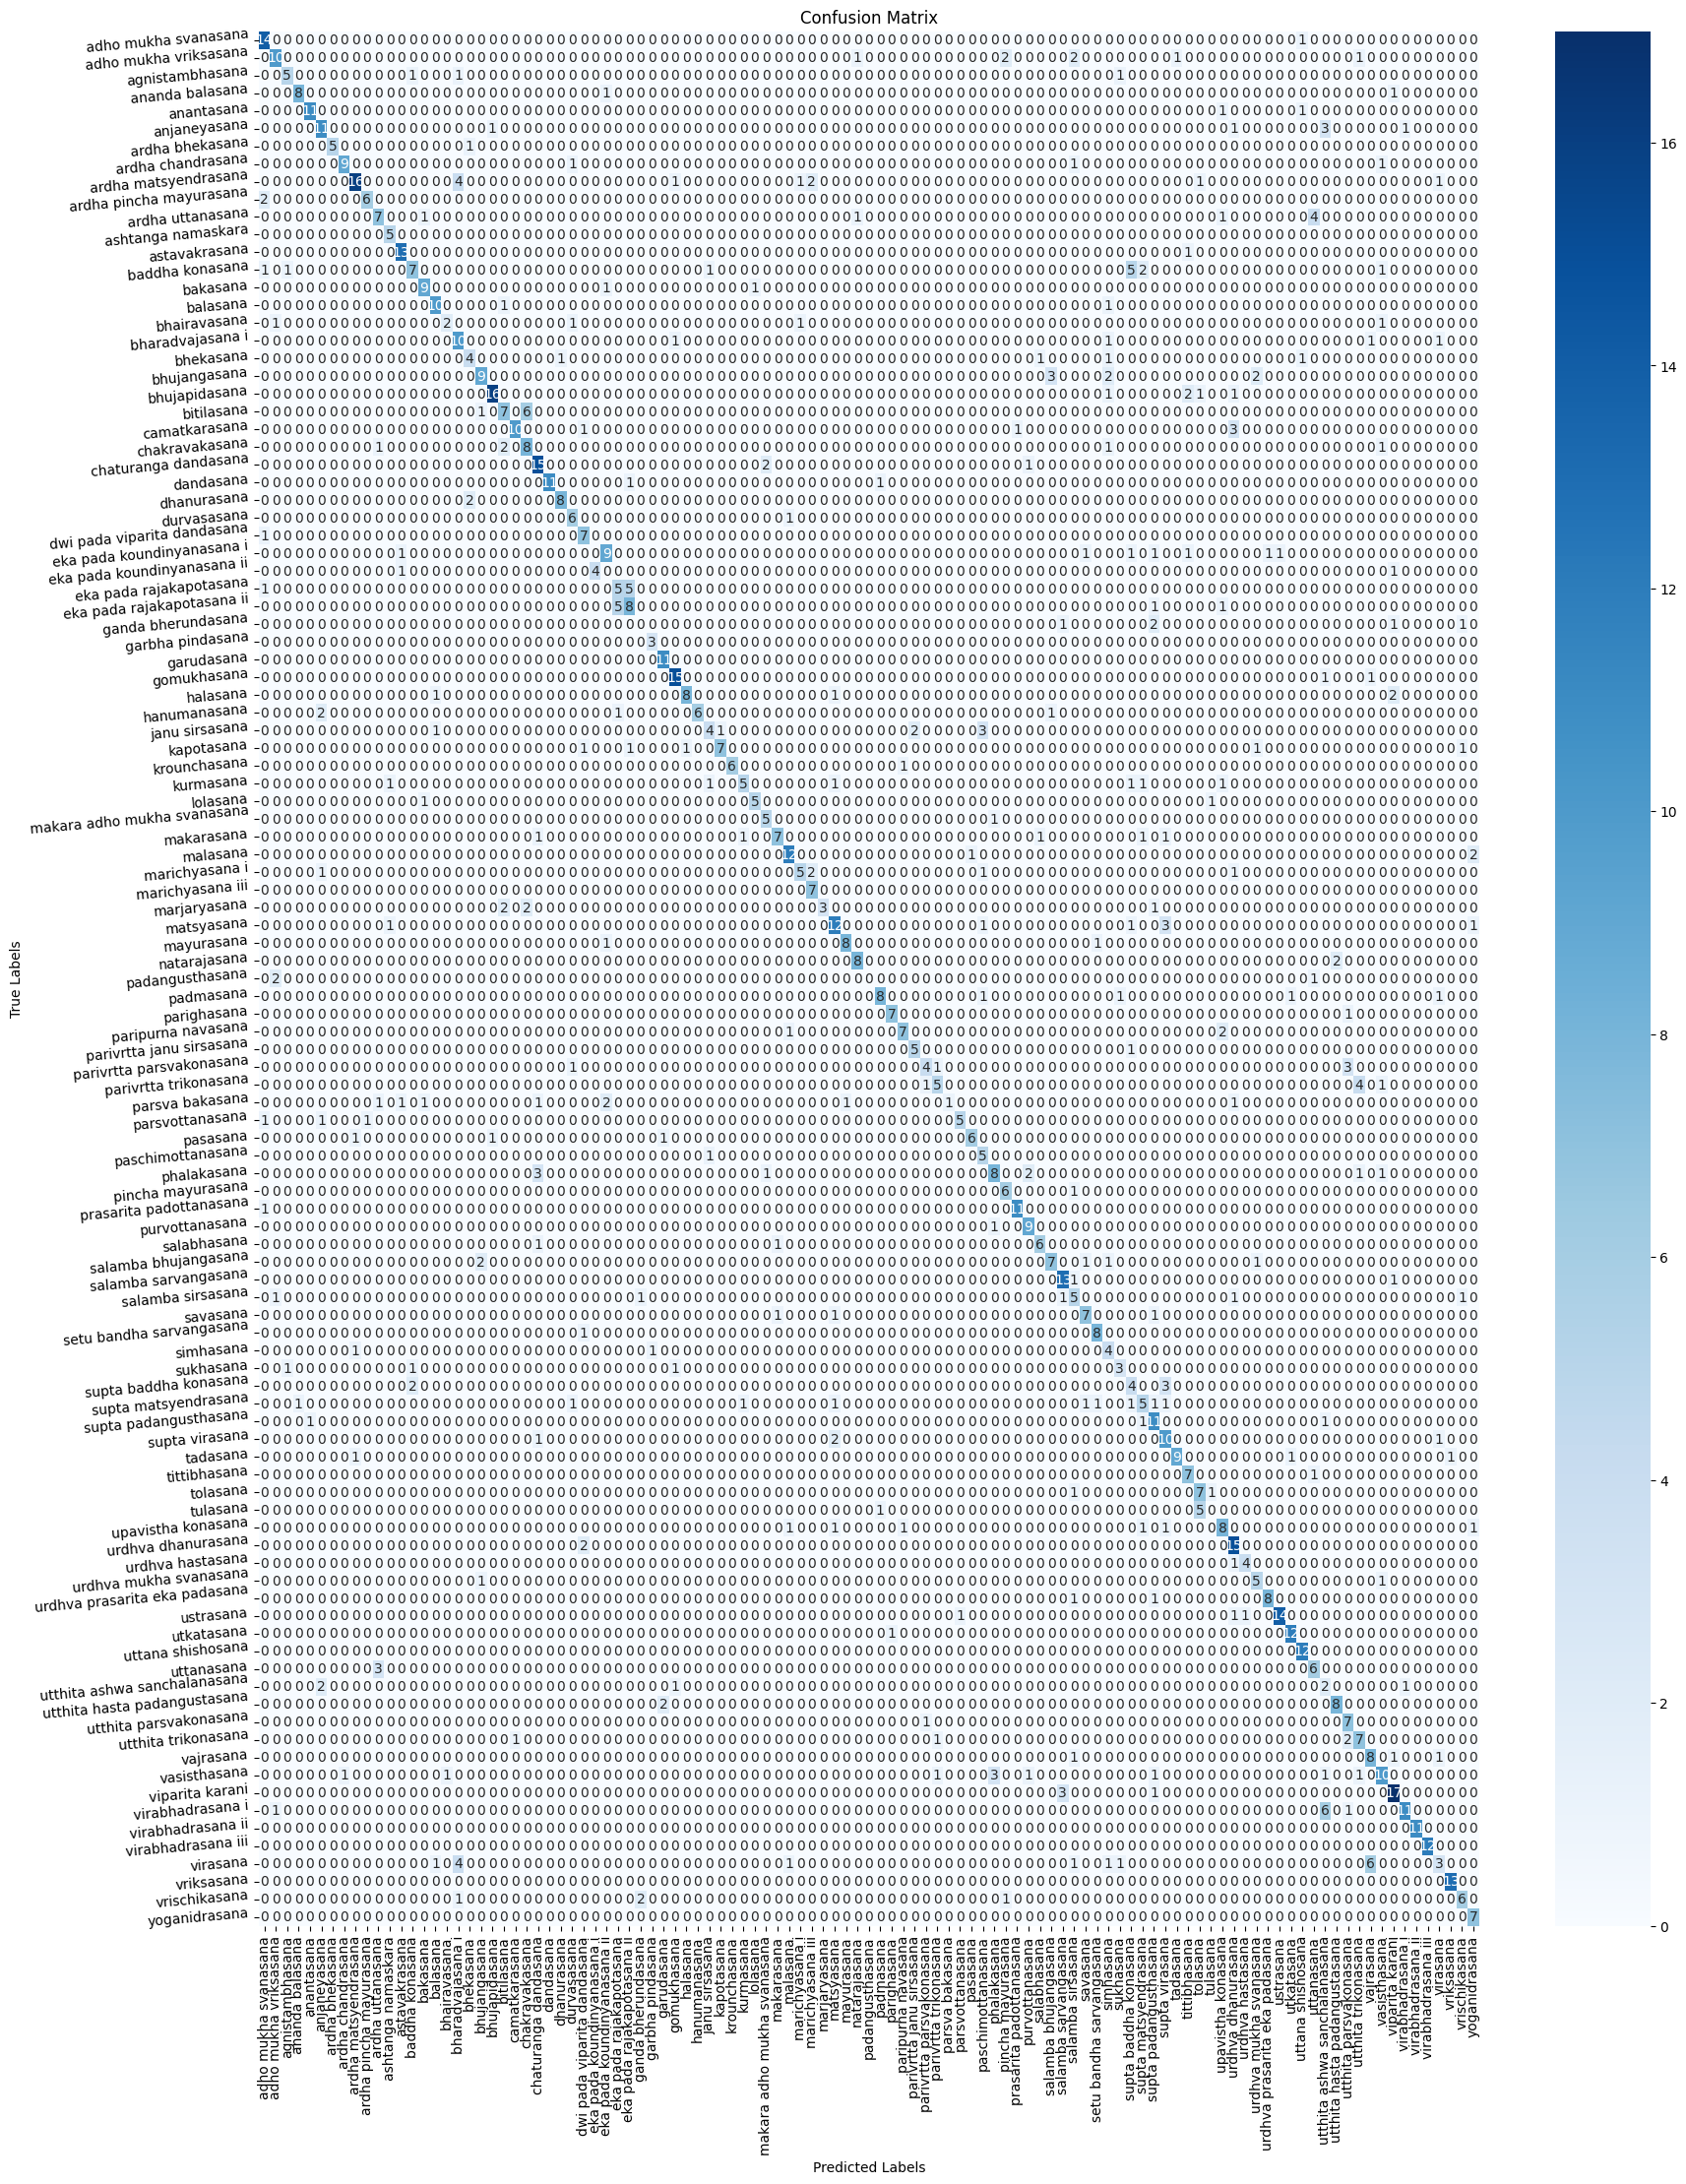

In [14]:
class_names = [label for label, idx in sorted(label_dict.items(), key=lambda item: item[1])]
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,25))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=5)
plt.show()

In [15]:
print("Classification Report:\n", classification_report(y_test, y_pred,target_names=class_names))

Classification Report:
                                precision    recall  f1-score   support

         adho mukha svanasana       0.67      0.93      0.78        15
        adho mukha vriksasana       0.67      0.59      0.62        17
              agnistambhasana       0.71      0.62      0.67         8
              ananda balasana       0.89      0.80      0.84        10
                   anantasana       0.92      0.85      0.88        13
                 anjaneyasana       0.65      0.65      0.65        17
              ardha bhekasana       1.00      0.83      0.91         6
            ardha chandrasana       0.90      0.75      0.82        12
         ardha matsyendrasana       0.84      0.62      0.71        26
      ardha pincha mayurasana       0.86      0.75      0.80         8
             ardha uttanasana       0.58      0.50      0.54        14
           ashtanga namaskara       0.71      1.00      0.83         5
                astavakrasana       0.81      0.93  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


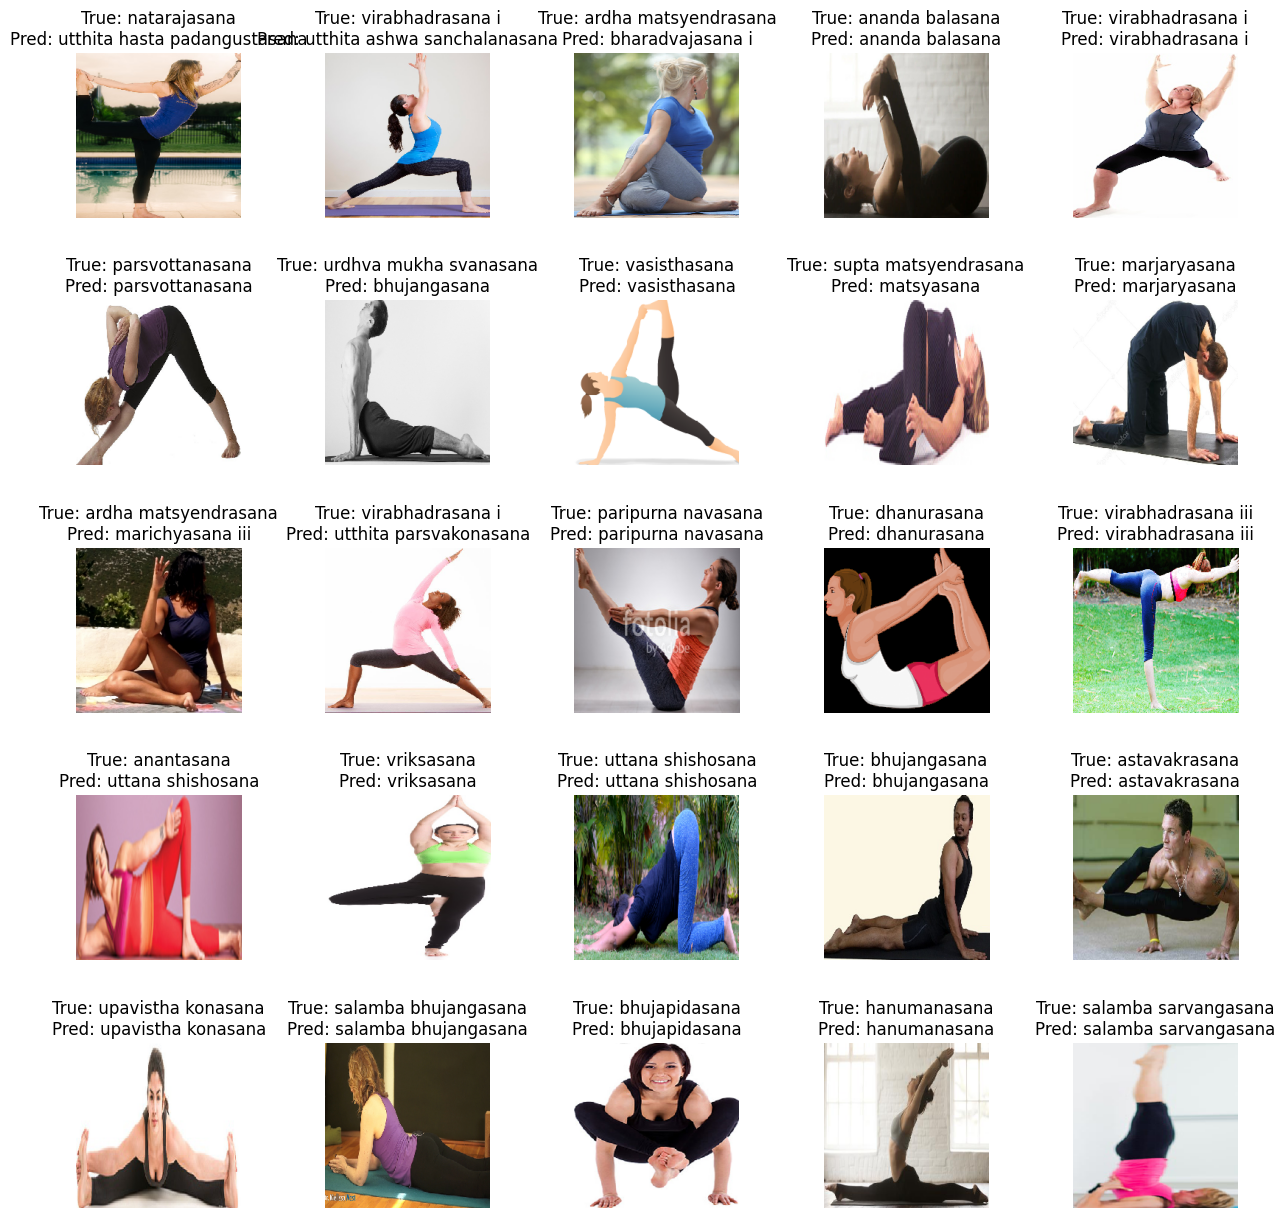

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# Base path to your dataset
image_path = "/kaggle/input/yoga-pose-image-classification-dataset/dataset/"

# Step 1: Collect all image paths and their labels
image_paths = []
image_labels = []
class_names = sorted(os.listdir(image_path))  # Assumes subfolders are class names

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(image_path, class_name)
    if os.path.isdir(class_dir):  # Check if it's a directory
        for img_file in os.listdir(class_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
                image_paths.append(os.path.join(class_dir, img_file))
                image_labels.append(label)  # Numeric label based on folder order

# Convert to arrays
image_paths = np.array(image_paths)
image_labels_data = np.array(image_labels)

# Step 2: Replicate your train_test_split to get test indices
_, test_indices = train_test_split(range(len(image_paths)), test_size=0.2, random_state=42)

# Step 3: Select 25 random test samples
indices = np.random.choice(len(test_indices), 25, replace=False)
sample_indices = [test_indices[i] for i in indices]  # Map to original indices
sample_images = [np.array(load_img(image_paths[i], target_size=(224, 224))) for i in sample_indices]
sample_labels = y_test[indices]
sample_pred = lr.predict(X_test[indices])

# Step 4: Plotting 5x5 grid of images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[sample_pred[i]]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


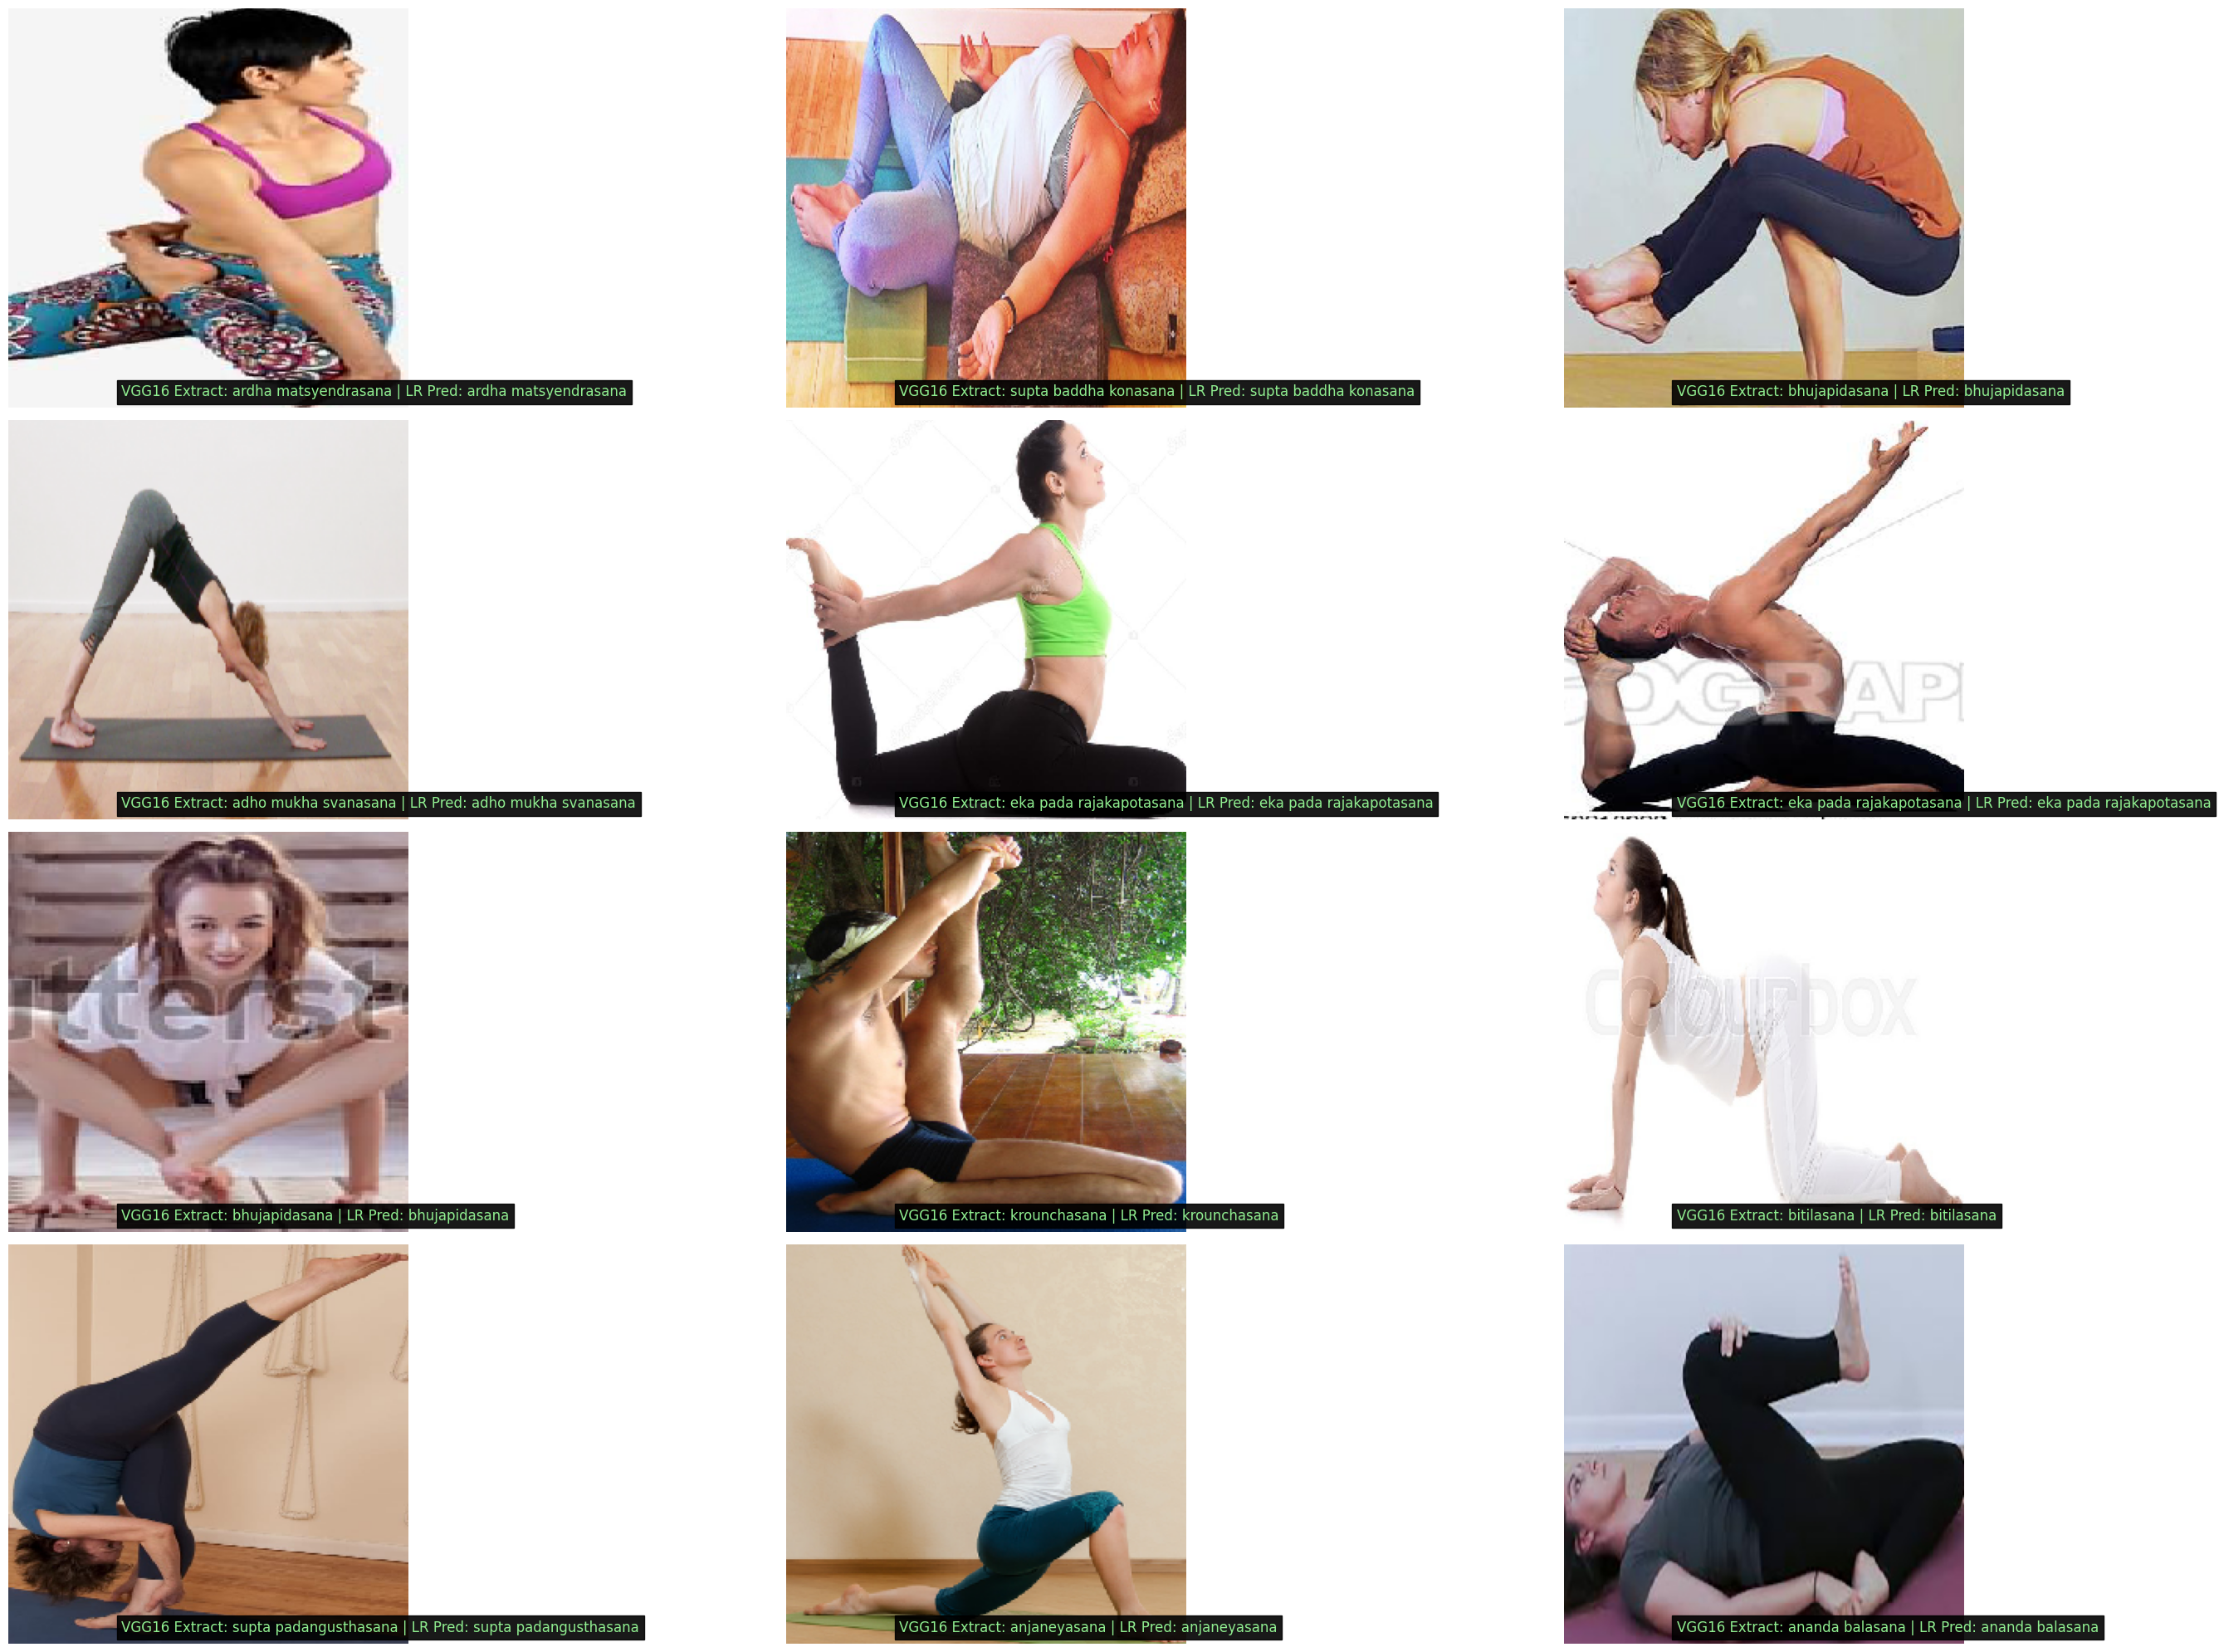

In [17]:
image_paths = []
image_labels = []
class_names = sorted(os.listdir(image_path))

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(image_path, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, img_file))
                image_labels.append(label)

image_paths = np.array(image_paths)
image_labels_data = np.array(image_labels)

_, test_indices = train_test_split(range(len(image_paths)), test_size=0.2, random_state=42)
image_paths_test = image_paths[test_indices]

test_sample = random.sample(list(image_paths_test), 12)

def test_img(test_sample, feature_model, classifier):
    result_lst = []
    for path in test_sample:
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        # Feature extraction using the feature model (e.g., VGG16)
        features = feature_model.predict(image)
        features = np.reshape(features, (-1, 7*7*512))
        
        # Classification prediction using Logistic Regression
        class_pred = classifier.predict(features)[0]
        
        # Store the feature extraction and prediction results
        result_lst.append((class_pred, features))  # Storing both predictions
    return result_lst

# Test with 12 sample images
pred_results = test_img(test_sample, model, lr)

# Plotting 4x3 grid of images with both predictions
plt.figure(figsize=(30, 20))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    result = pred_results[i]
    class_pred = result[0]  # Logistic Regression prediction
    img_path = test_sample[i]
    image = load_img(img_path, target_size=(256, 256))

    # Display both predictions in the title: 
    plt.text(72, 248, f'VGG16 Extract: {class_names[class_pred]} | LR Pred: {class_names[class_pred]}', 
             color='lightgreen', fontsize=12, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()
